In [2]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm
import pandas as pd

import IPython.display

from dask.distributed import Client

%matplotlib inline

In [3]:
### Dask client
client = Client(n_workers=8)
display(client)

### Generate new session
db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34881/status,
Dashboard: /proxy/34881/status,Workers: 8
Total threads: 8,Total memory: 90.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43263,Workers: 8
Dashboard: /proxy/34881/status,Total threads: 8
Started: Just now,Total memory: 90.00 GiB
Comm: tcp://127.0.0.1:43005,Total threads: 1
Dashboard: /proxy/43381/status,Memory: 11.25 GiB
Nanny: tcp://127.0.0.1:33953,


### ACCESS-OM2

In [4]:
yr_beg = '2400-02-01'
yr_end = '2499-12-31'
expt = '1deg_jra55_ryf_cont'

var = 'temp'
frequency = '1 monthly'
access_temp_cont = cc.querying.getvar(expt, var, session, frequency=frequency, start_time = yr_beg, end_time = yr_end).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

# Load mask for Hovmöller

var = 'area_t'
area_t = cc.querying.getvar(expt, var, session, n=1)#.mean('time')
mask = access_temp_cont.isel(year=0).copy()
mask = mask / mask                 ## This seems pretty dodgy to me, but it works!
area = mask * area_t
area_sum = area.sum('xt_ocean').sum('yt_ocean')
IPython.display.clear_output()

access_hov_sinusoids = []
access_periods = [2, 5, 10, 20]

# Compute Hovmöller

for i in range(len(access_periods)):
    expt = f'1deg_jra55_ryf_sinusoid_x1_period{access_periods[i]}'
    var = 'temp'
    frequency = '1 monthly'
    
    temp_anom = cc.querying.getvar(expt, var, session, frequency=frequency, start_time = yr_beg, end_time = yr_end).groupby('time.year').mean(dim='time').chunk(chunks='auto') - access_temp_cont
    hov = (((area_t * temp_anom).sum('xt_ocean').sum('yt_ocean')) / area_sum).load()
    
    access_hov_sinusoids.append(hov)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

### 1D model

In [5]:
# Constants, data, parameters

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-6
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz / 2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (i.e., need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top / bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking for simplicity 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top / bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e., evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e., evaluated at the top / bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T

def sin(amp, period):
    period_day = period * 360
    return amp * np.sin((2 * np.pi / period_day) * t)

In [6]:
### Run experiment

years = 100
days = dt / 86400
M = int(z_b / dz)
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)
onedim_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)

# Variable forcing

onedim_periods = np.array([2, 5, 10, 20])
Q = 8
T0 = 1.0

onedim_sinusoids = np.zeros(shape = (M, N+1, onedim_periods.shape[0]))

for p in range(len(onedim_periods)):
    onedim_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(Q, onedim_periods[p]), sin(T0, onedim_periods[p]), years)

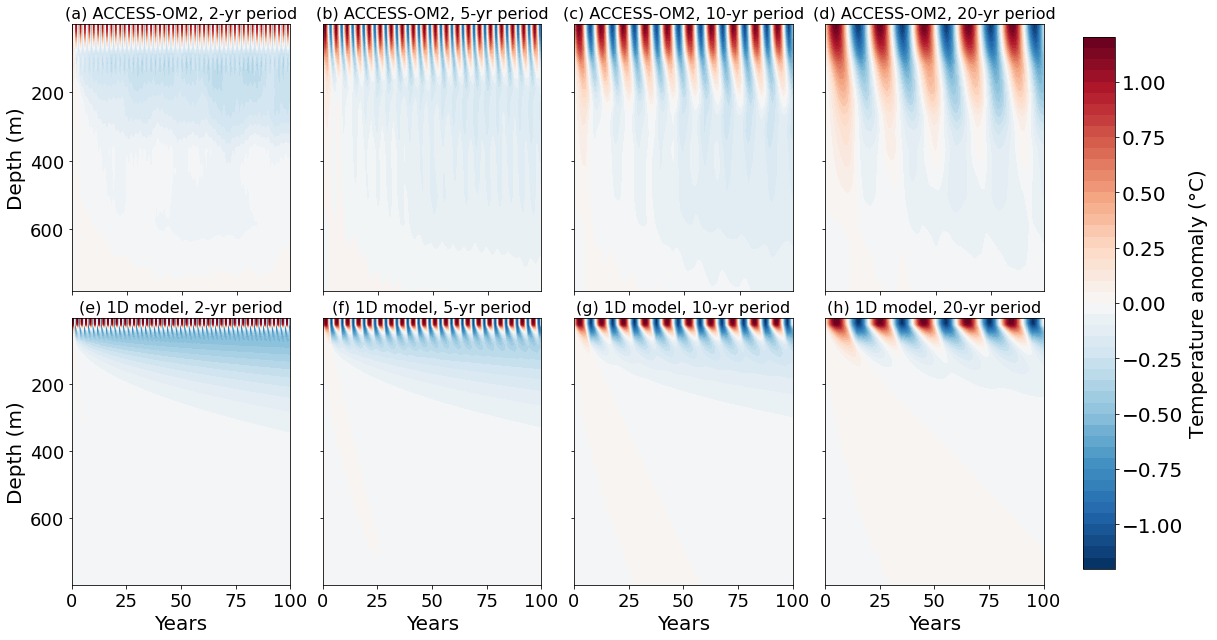

In [17]:
### Plot both ACCESS and 1D model volume-average temperatures

### Time axis for 1D model
timesteps = onedim_cont.shape[1]
length = (timesteps - 1) * days / 360
time_years = np.linspace(0,length,timesteps)
tt, zz = np.meshgrid(time_years, z_t[:-40])

fig = plt.figure(figsize=(18,9))
names = ['2-yr period', '5-yr period', '10-yr period', '20-yr period']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

depth = 800
levels= 51
cmap = 'RdBu_r'
fontsize=20

for i in range(4):
    
    ### ACCESS-OM2
    ax = fig.add_subplot(2, 4, i+1)
    im = access_hov_sinusoids[i].sel(st_ocean = slice(None, depth)).T.plot.contourf(ax=ax, levels=levels, yincrease=False, add_colorbar=False, cmap = cmap)
    ax.set_title(f'{labels[i]} ACCESS-OM2, {names[i]}', fontsize=fontsize-4)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
    # ax.set_yticklabels([200,400,600])
    if i == 0:
        ax.set_ylabel('Depth (m)', fontsize=fontsize)
    else:
        ax.set_yticklabels('')
    ax.set_xticklabels('')
    # ax.set_xticklabels([0,25,50,75,100])
    ax.tick_params(labelsize=fontsize-2)
    
    ### 1D model
    ax = fig.add_subplot(2, 4, i+1+4)
    im = ax.contourf(tt, zz, (onedim_sinusoids[:,:,i] - onedim_cont)[:-40], levels=51, cmap=cmap, norm=TwoSlopeNorm(0)) 
    ax.set_title(f'{labels[i+4]} 1D model, {names[i]}', fontsize=fontsize-4)
    ax.set_xlabel('Years', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
    if i == 0:
        ax.set_ylabel('Depth (m)', fontsize=fontsize)
    else:
        ax.set_yticklabels('')
    ax.tick_params(labelsize=fontsize-2)
    ax.invert_yaxis()

plt.subplots_adjust(left=0.1,
                    bottom=None, 
                    right=0.9, 
                    top=0.99, 
                    wspace=0.15, 
                    hspace=0.1)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.025, 0.82]) # left bottom width height
cbar = plt.colorbar(im, cax = cbar_ax)
cbar.set_label(label='Temperature anomaly ($\degree$C)', size=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.savefig('Fig10.pdf', bbox_inches='tight', dpi=200)